# CNN Aiming for Higfher Performance

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

### Intermediate Data Labels

In [4]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

In [5]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

## CNN Architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,     # 1 channel for grayscale images
                  out_channels=32,                # 32 kernels/filters, so 32 output channels
                  kernel_size=3,                  # 3x3 convolutional kernel
                  stride=1,                       # move the kernel 1 pixel at a time
                  padding=1)                      # pad the input so the output size remains 28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # this will reduce the dimensions by a factor of 2

        self.conv2 = nn.Conv2d(in_channels=32,   
                  out_channels=64,                
                  kernel_size=3,                 
                  stride=1,                      
                  padding=1)                     
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        # convolutional layer 1
        conv_out = self.conv1(x)
        conv_act = self.activation_function(conv_out)

        # pooling layer 1
        pool_out = self.pool1(conv_act)

        # convolutional layer 2
        conv_out2 = self.conv2(pool_out)
        conv_act2 = self.activation_function(conv_out2)

        # pooling layer 2
        pool_out2 = self.pool2(conv_act2)

        # hidden layer
        fc1_in = pool_out2.view(pool_out2.size(0), -1)
        fc1_out = self.fc1(fc1_in)
        fc1_act = self.activation_function(fc1_out)

        # classification
        classification_out = self.fc2(fc1_act)
        
        return classification_out, conv_act

In [7]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
model = CNN().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [9]:
print(f"Model weights (to compare below): {model.conv1.weight[0].detach().cpu().numpy()}")

Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]


What we should see from the above weight matrix output, to verify reproducibility:

```
Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]
```

## Dataloader

In [10]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).unsqueeze(0).float()
        
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)
        horizontal_edge = torch.from_numpy(self.horizontal_edges[idx].copy()).unsqueeze(0).float()
        vertical_edge = torch.from_numpy(self.vertical_edges[idx].copy()).unsqueeze(0).float()

        return image, label, horizontal_edge, vertical_edge

In [11]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [12]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [13]:
num_epochs = 20
best_val_loss = float('inf')
loss_factor = 0
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, _, _ = batch
        images, labels = images.to(device).float(), labels.to(device)
        
        # forward pass
        classification_out, conv_act  = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Epoch 1/20
  Train Loss: 0.2844
  Val Loss: 0.0626 | Val Acc: 98.03%


Epoch 2/20
  Train Loss: 0.0545
  Val Loss: 0.0679 | Val Acc: 98.07%


Epoch 3/20
  Train Loss: 0.0400
  Val Loss: 0.0678 | Val Acc: 98.14%


Epoch 4/20
  Train Loss: 0.0314
  Val Loss: 0.0572 | Val Acc: 98.70%


Epoch 5/20
  Train Loss: 0.0325
  Val Loss: 0.0518 | Val Acc: 98.52%


Epoch 6/20
  Train Loss: 0.0211
  Val Loss: 0.0628 | Val Acc: 98.38%


Epoch 7/20
  Train Loss: 0.0219
  Val Loss: 0.0724 | Val Acc: 98.41%


Epoch 8/20
  Train Loss: 0.0167
  Val Loss: 0.0743 | Val Acc: 98.35%


Epoch 9/20
  Train Loss: 0.0198
  Val Loss: 0.0847 | Val Acc: 98.36%


Epoch 10/20
  Train Loss: 0.0165
  Val Loss: 0.0806 | Val Acc: 98.53%


Epoch 11/20
  Train Loss: 0.0165
  Val Loss: 0.1055 | Val Acc: 98.36%


Epoch 12/20
  Train Loss: 0.0160
  Val Loss: 0.1077 | Val Acc: 98.36%


Epoch 13/20
  Train Loss: 0.0139
  Val Loss: 0.0929 | Val Acc: 98.38%


Epoch 14/20
  Train Loss: 0.0113
  Val Loss: 0.1310 | Val Acc: 98.32%


Epoch 15/20
  Train Loss: 0.0153
  Val Loss: 0.1305 | Val Acc: 98.16%


Epoch 16/20
  Train Loss: 0.0124
  Val Loss: 0.1073 | Val Acc: 98.60%


Epoch 17/20
  Train Loss: 0.0158
  Val Loss: 0.0963 | Val Acc: 98.80%


Epoch 18/20
  Train Loss: 0.0136
  Val Loss: 0.1182 | Val Acc: 98.40%


Epoch 19/20
  Train Loss: 0.0049
  Val Loss: 0.1185 | Val Acc: 98.68%


Epoch 20/20
  Train Loss: 0.0178
  Val Loss: 0.1695 | Val Acc: 98.04%


## Evaluation

In [14]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 357.22it/s]

Final Test Accuracy: 98.29%


# Seeing Activations

In [16]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, conv_act = model(img_tensor)

        # Process each channel separately
        act_imgs = []

        # Process filters
        for i in range(conv_act.size(1)):  # Loop through channels
            o_channel = conv_act[0, i].detach().cpu().numpy()
            act_imgs.append(o_channel)

        label = test_labels[idx]
        eval_examples.append((label, img, out, act_imgs))

In [28]:
def visualize_kernel_activations(img, label, act_imgs, prediction=None):
    """
    Visualize the original image and the activations from interpretable kernels.
    
    Args:
        img: Original input image
        label: True label
        v_act_imgs: List of vertical edge filter activations
        h_act_imgs: List of horizontal edge filter activations
        prediction: Model's prediction (optional)
    """
    # Determine number of filters
    n_filters = len(act_imgs)
    
    # Calculate rows needed for unrestricted filters (4 per row)
    n_rows = (n_filters + 3) // 4  # Ceiling division
    
    # Total rows: 2 for interpretable filters + rows for unrestricted filters
    total_rows = 2 + n_rows
    
    # Create figure with subplots
    fig, axes = plt.subplots(total_rows, 5, figsize=(20, 5 * total_rows))
    
    # Display original image
    axes[0, 0].imshow(img, cmap='gray')
    title = f"Original (Label: {label})"
    if prediction is not None:
        pred_label = np.argmax(prediction.detach().cpu().numpy())
        title += f"\nPredicted: {pred_label}"
    axes[0, 0].set_title(title)
    axes[0, 0].axis('off')
    
    axes[1, 0].axis('off')  # Empty spot in the grid

    for row in range(2):
        for col in range(5):
            axes[row, col].axis('off')

    # Display unrestricted filter activations, 4 per row
    for i in range(n_filters):
        row = 0 + (i // 4)  # Integer division to determine row
        col = i % 4 + 1     # Modulo to determine column (starting from 1)

        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].imshow(act_imgs[i], cmap='gray')
            axes[row, col].set_title(f"U-Filter {i+1}")
            axes[row, col].axis('off')
        
            # First column of each unrestricted filter row is empty
            axes[row, 0].axis('off')
    
    plt.tight_layout()

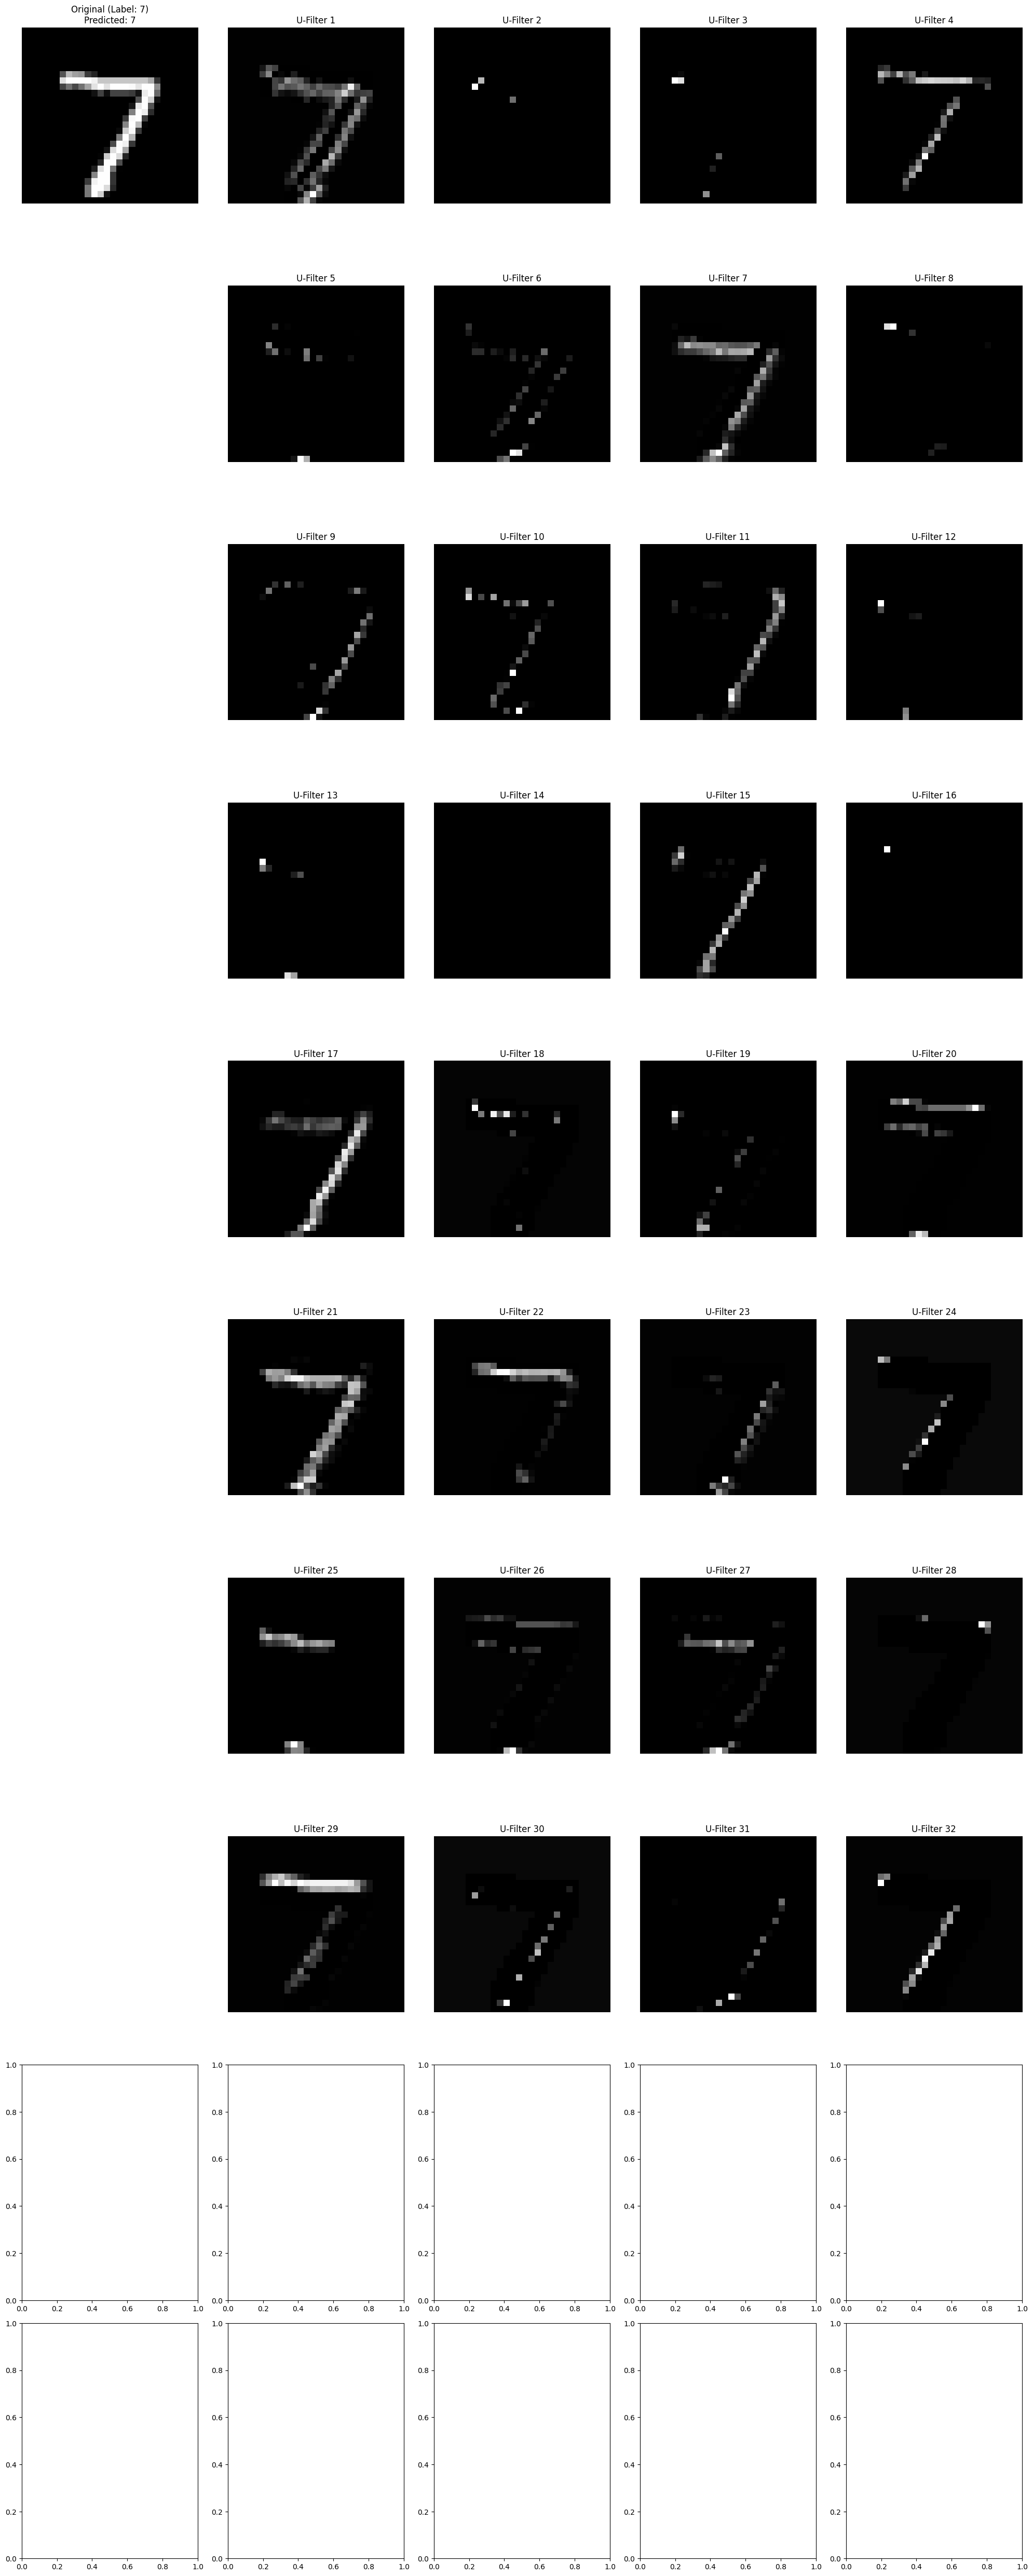

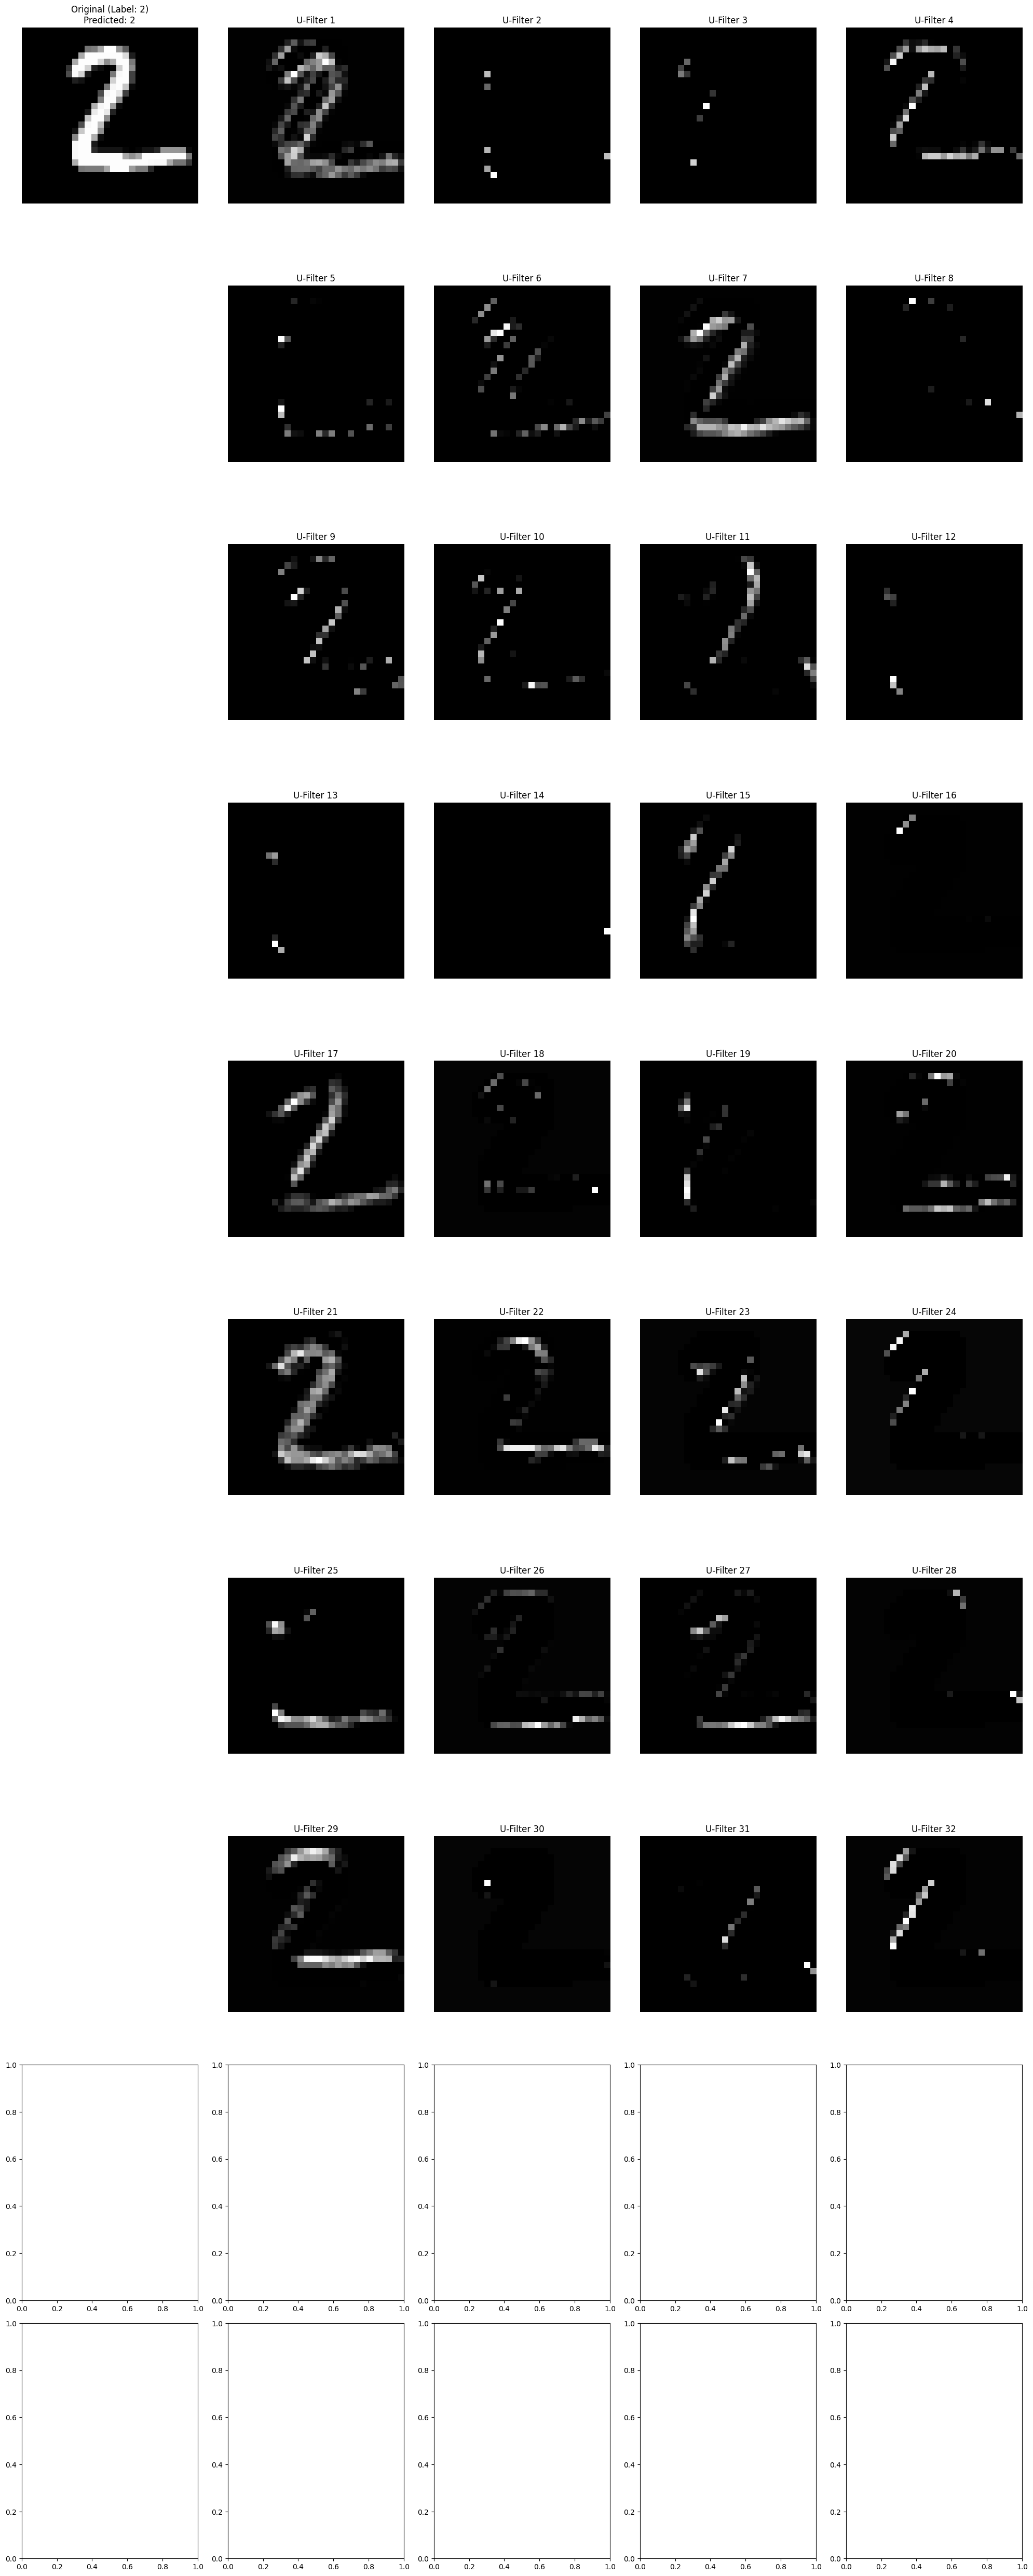

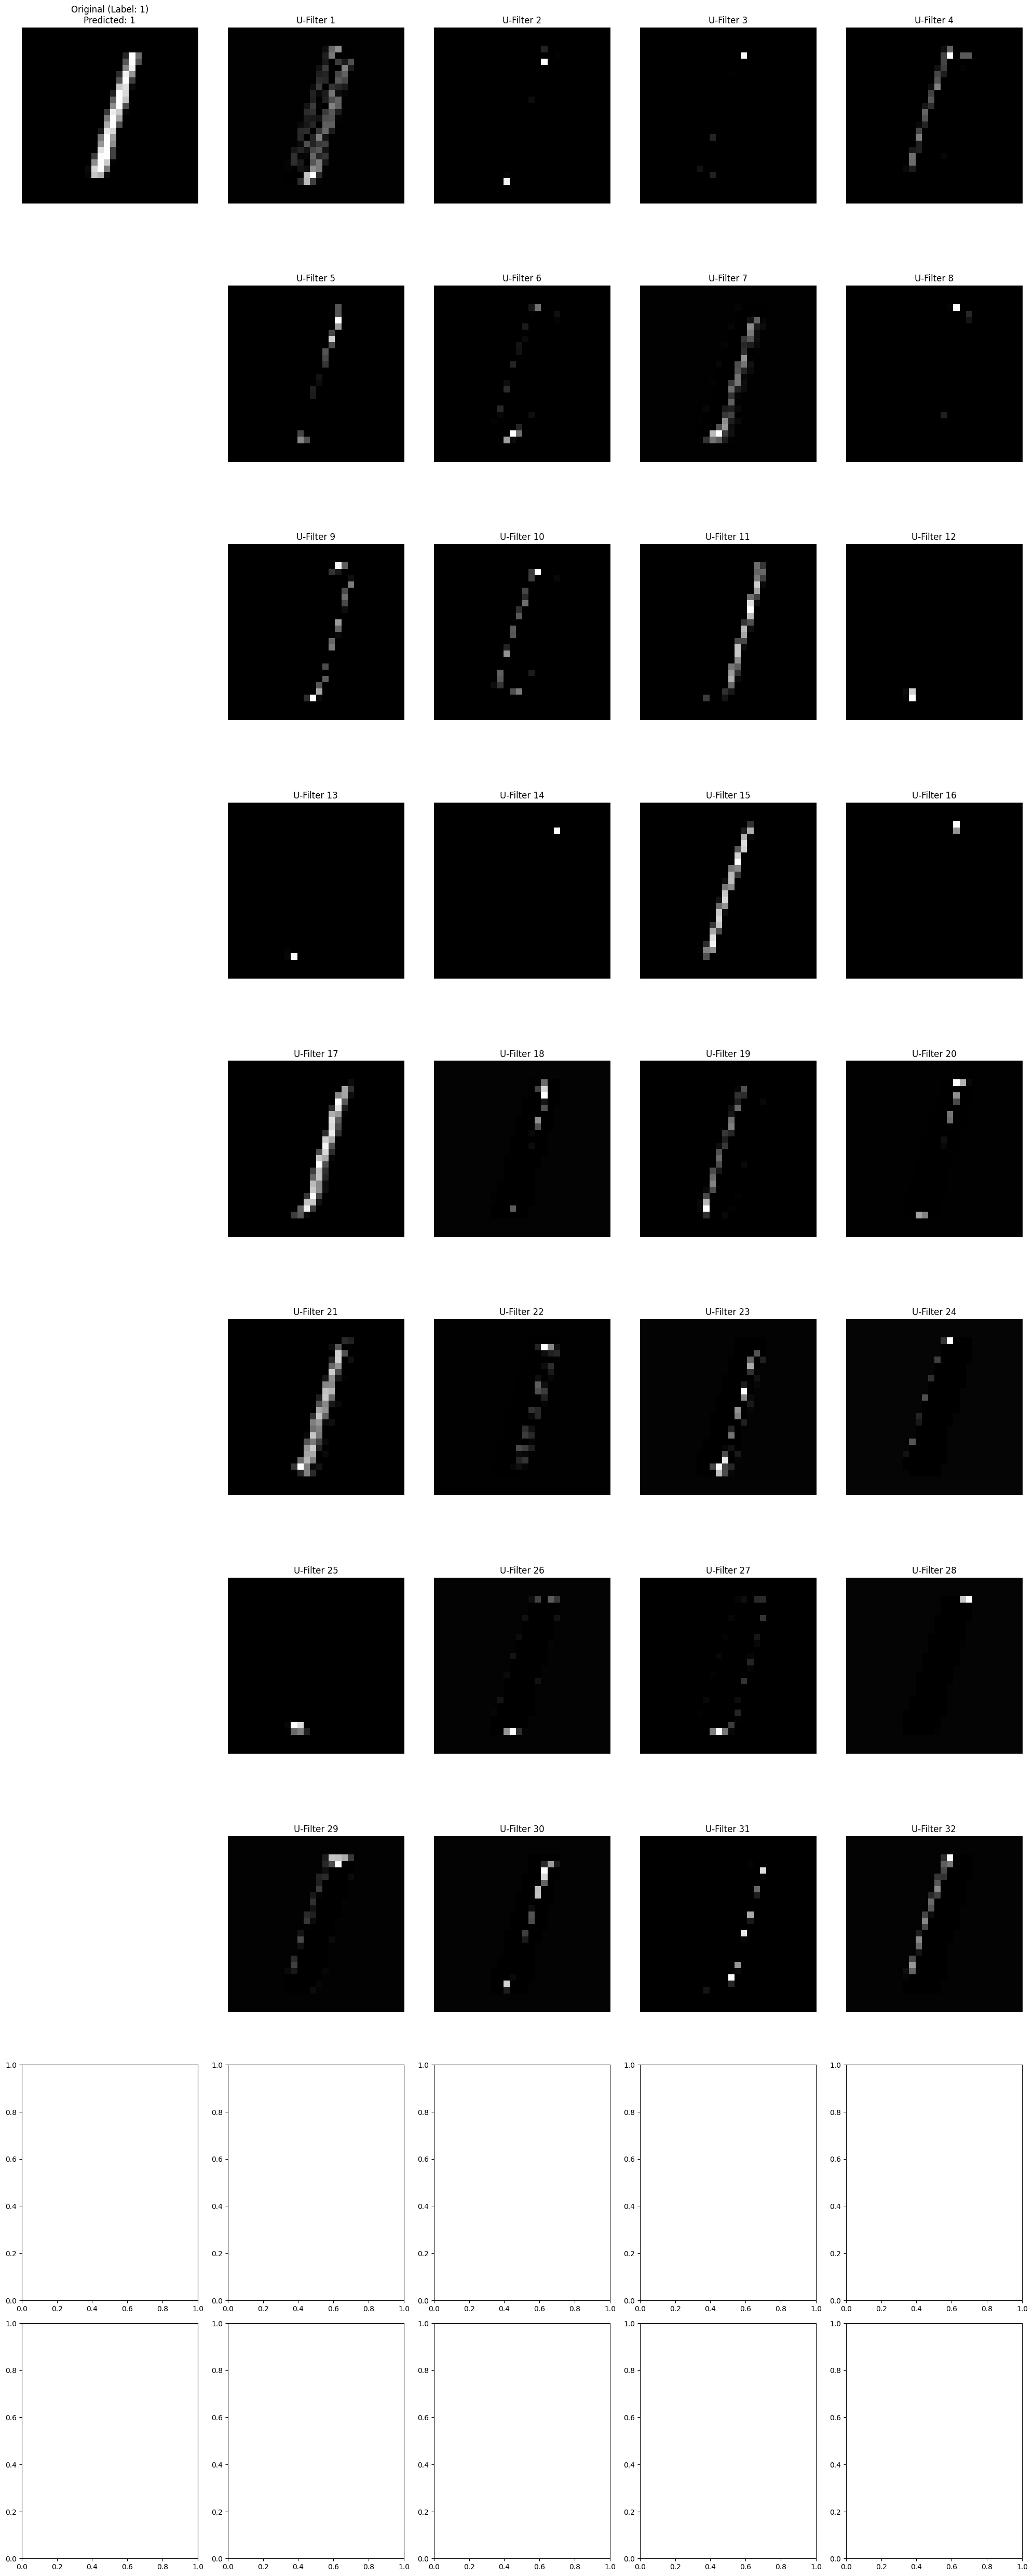

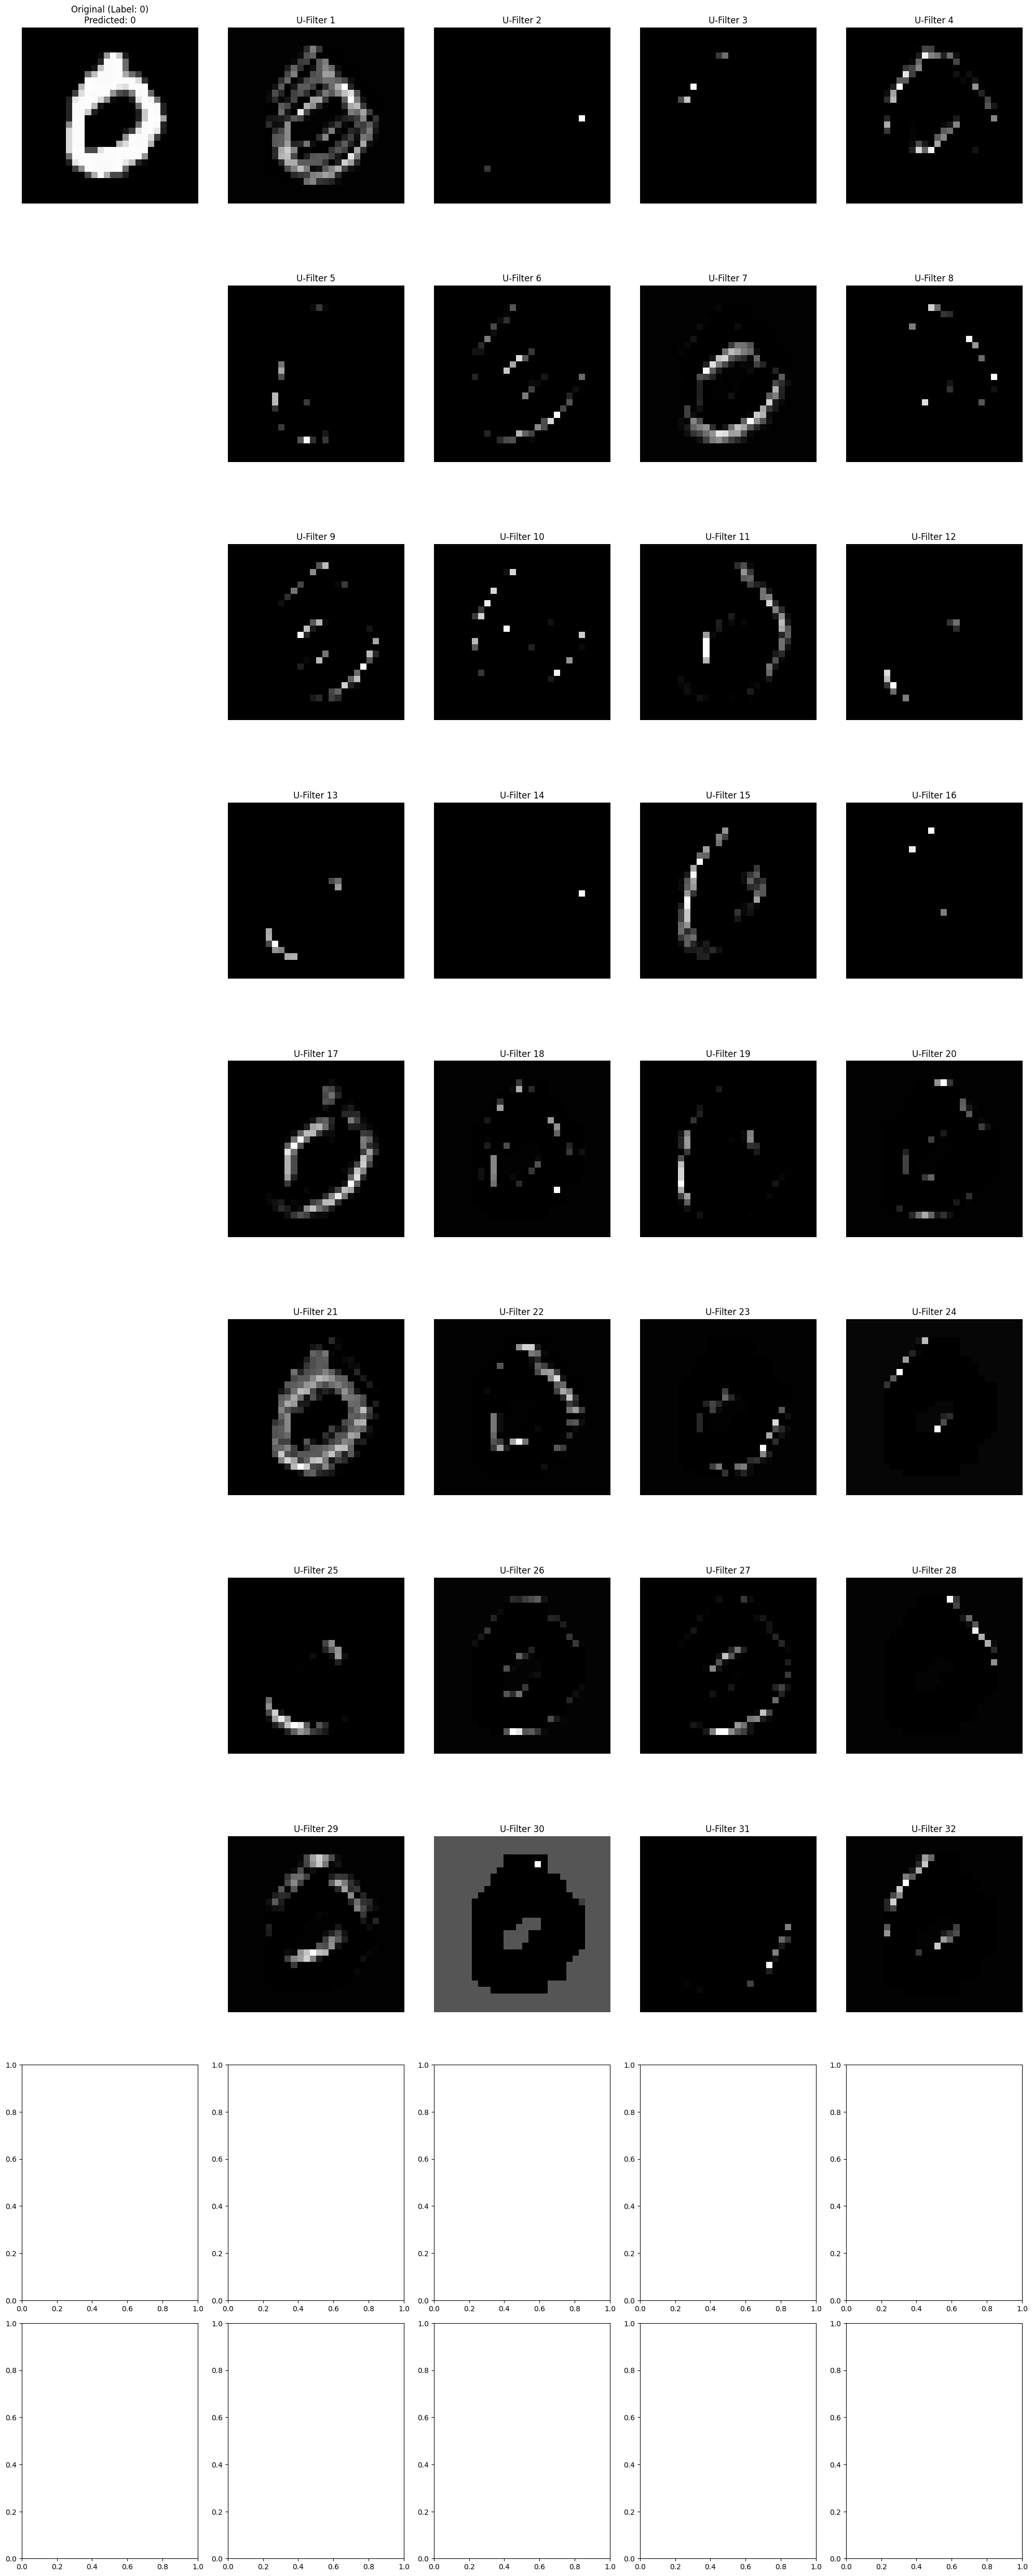

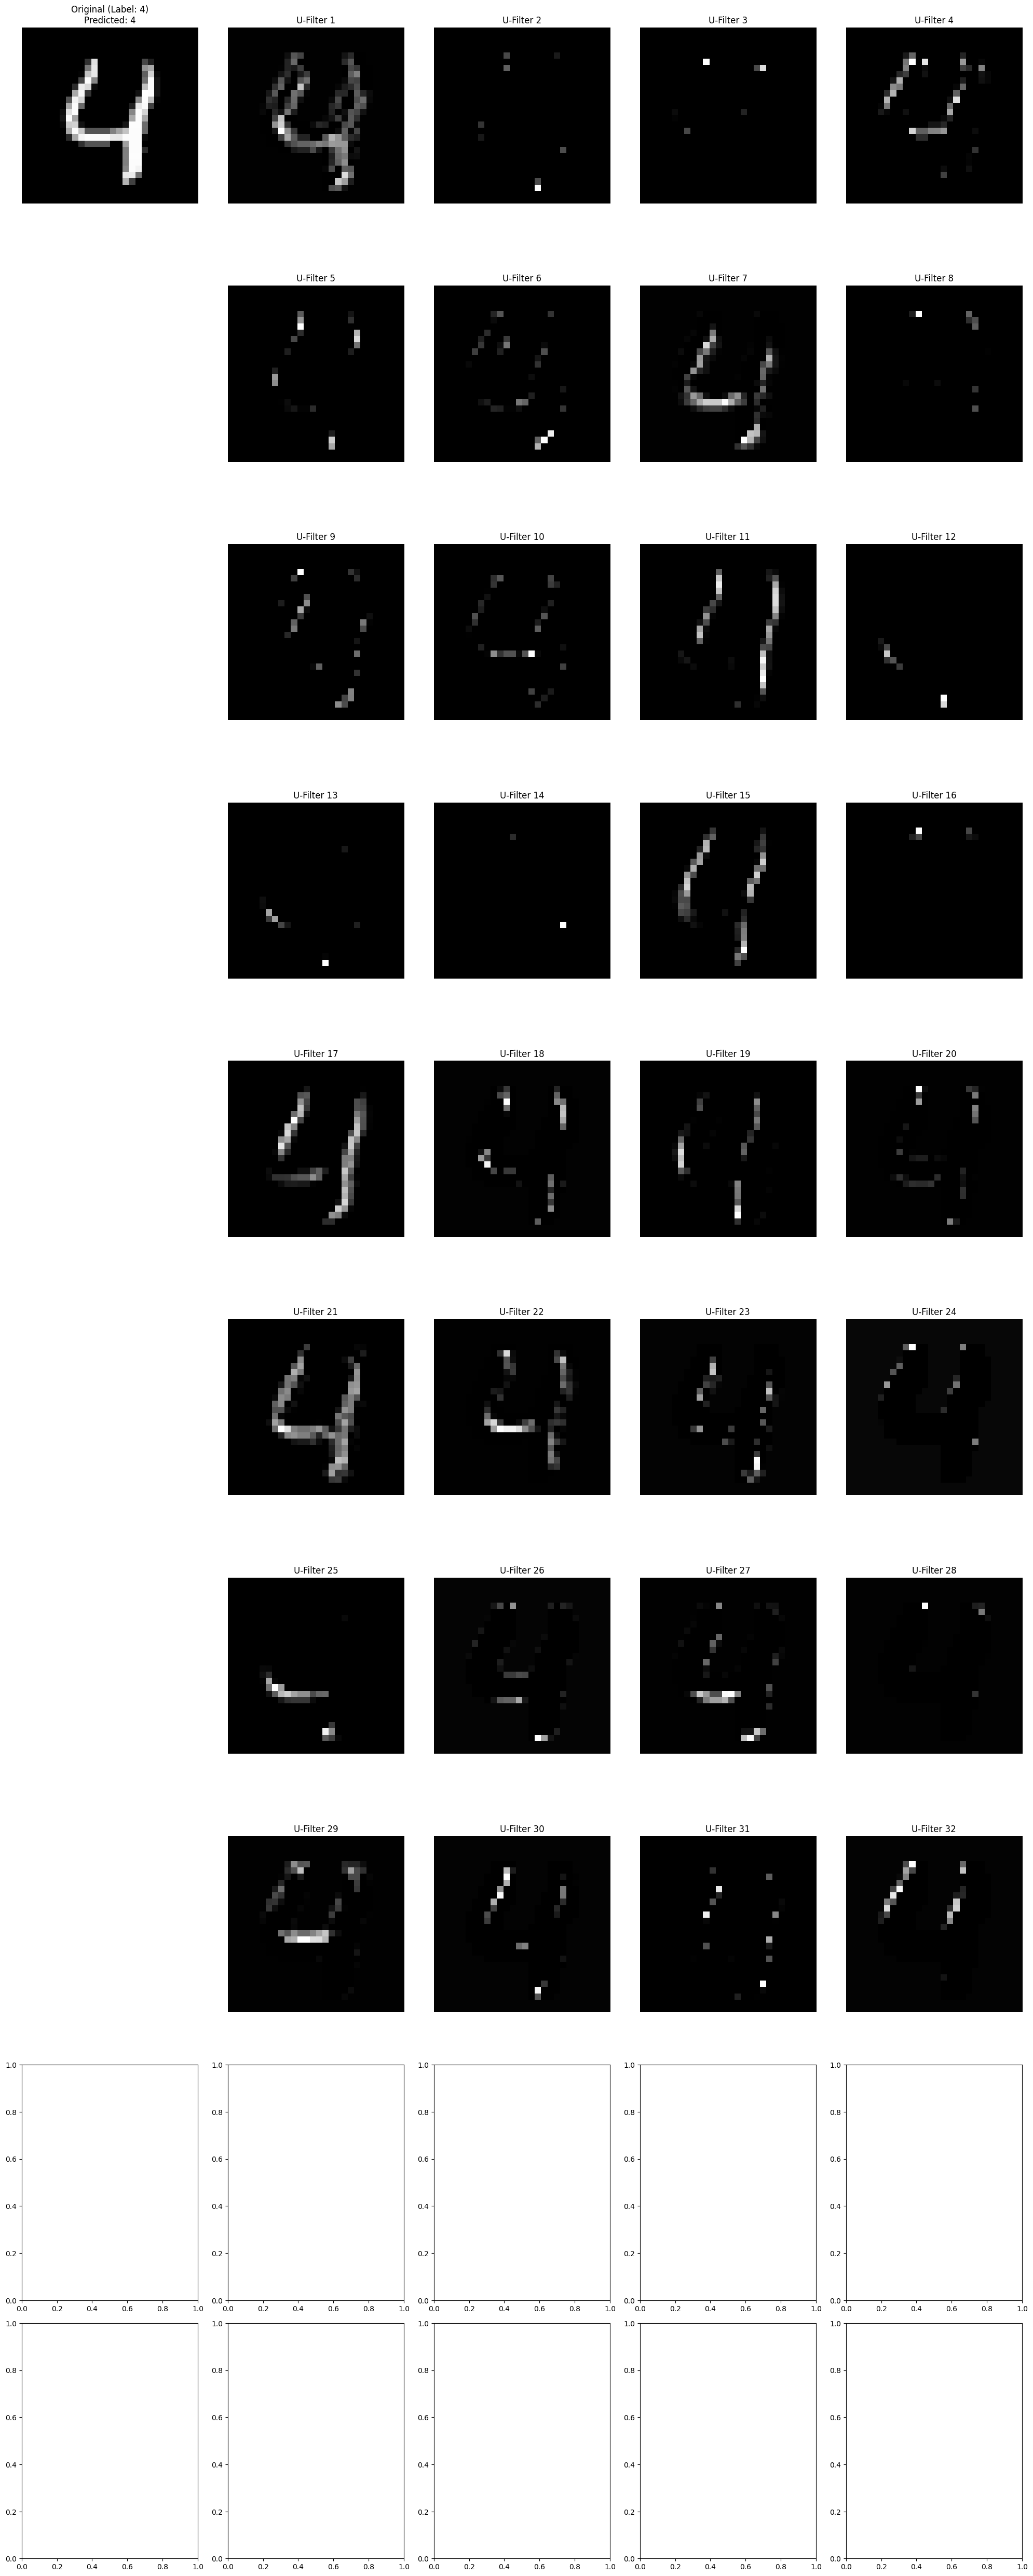

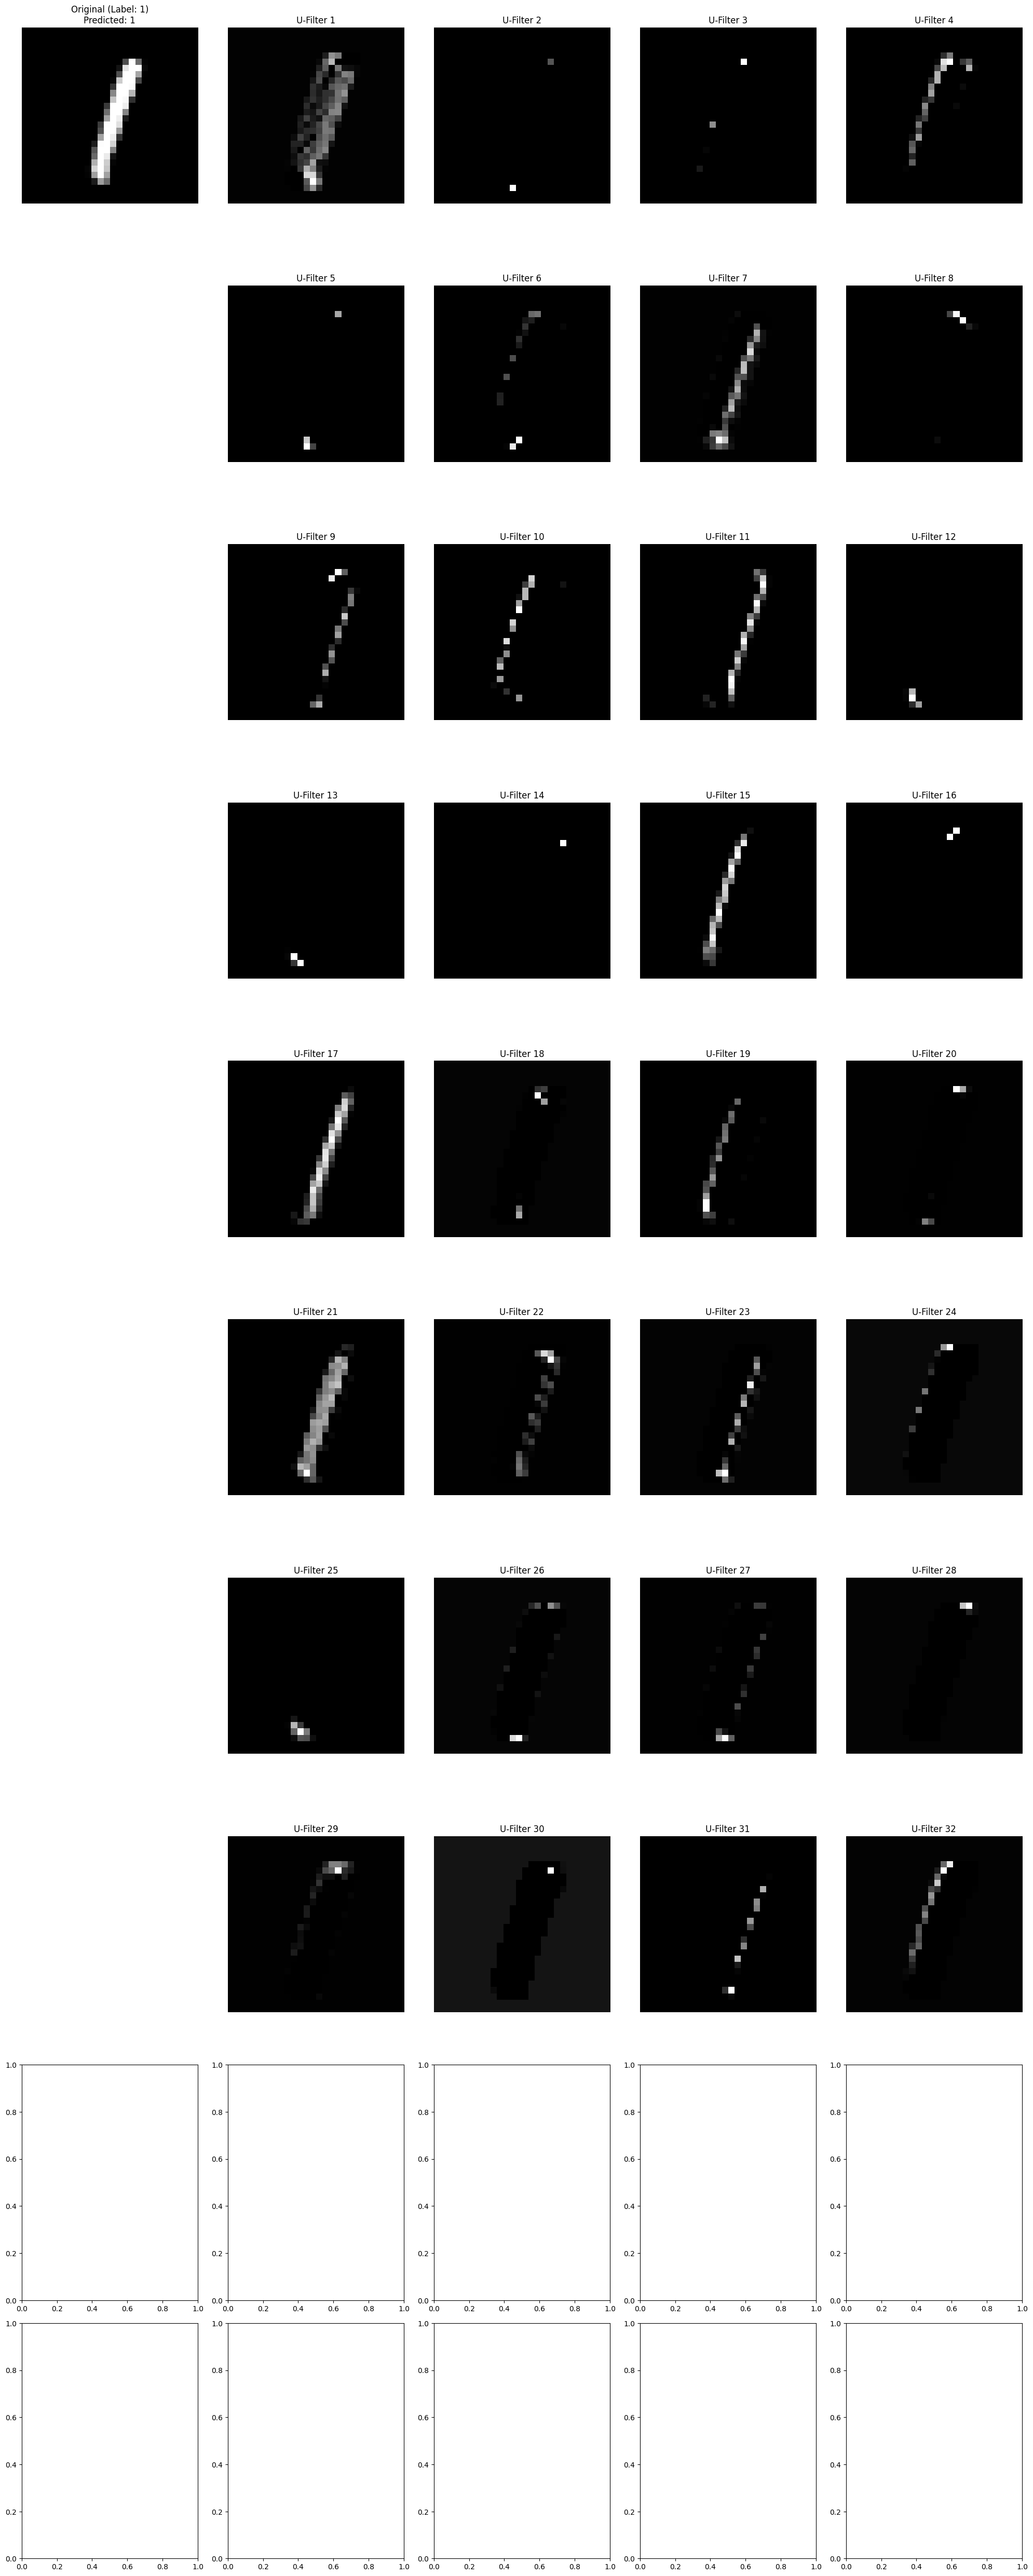

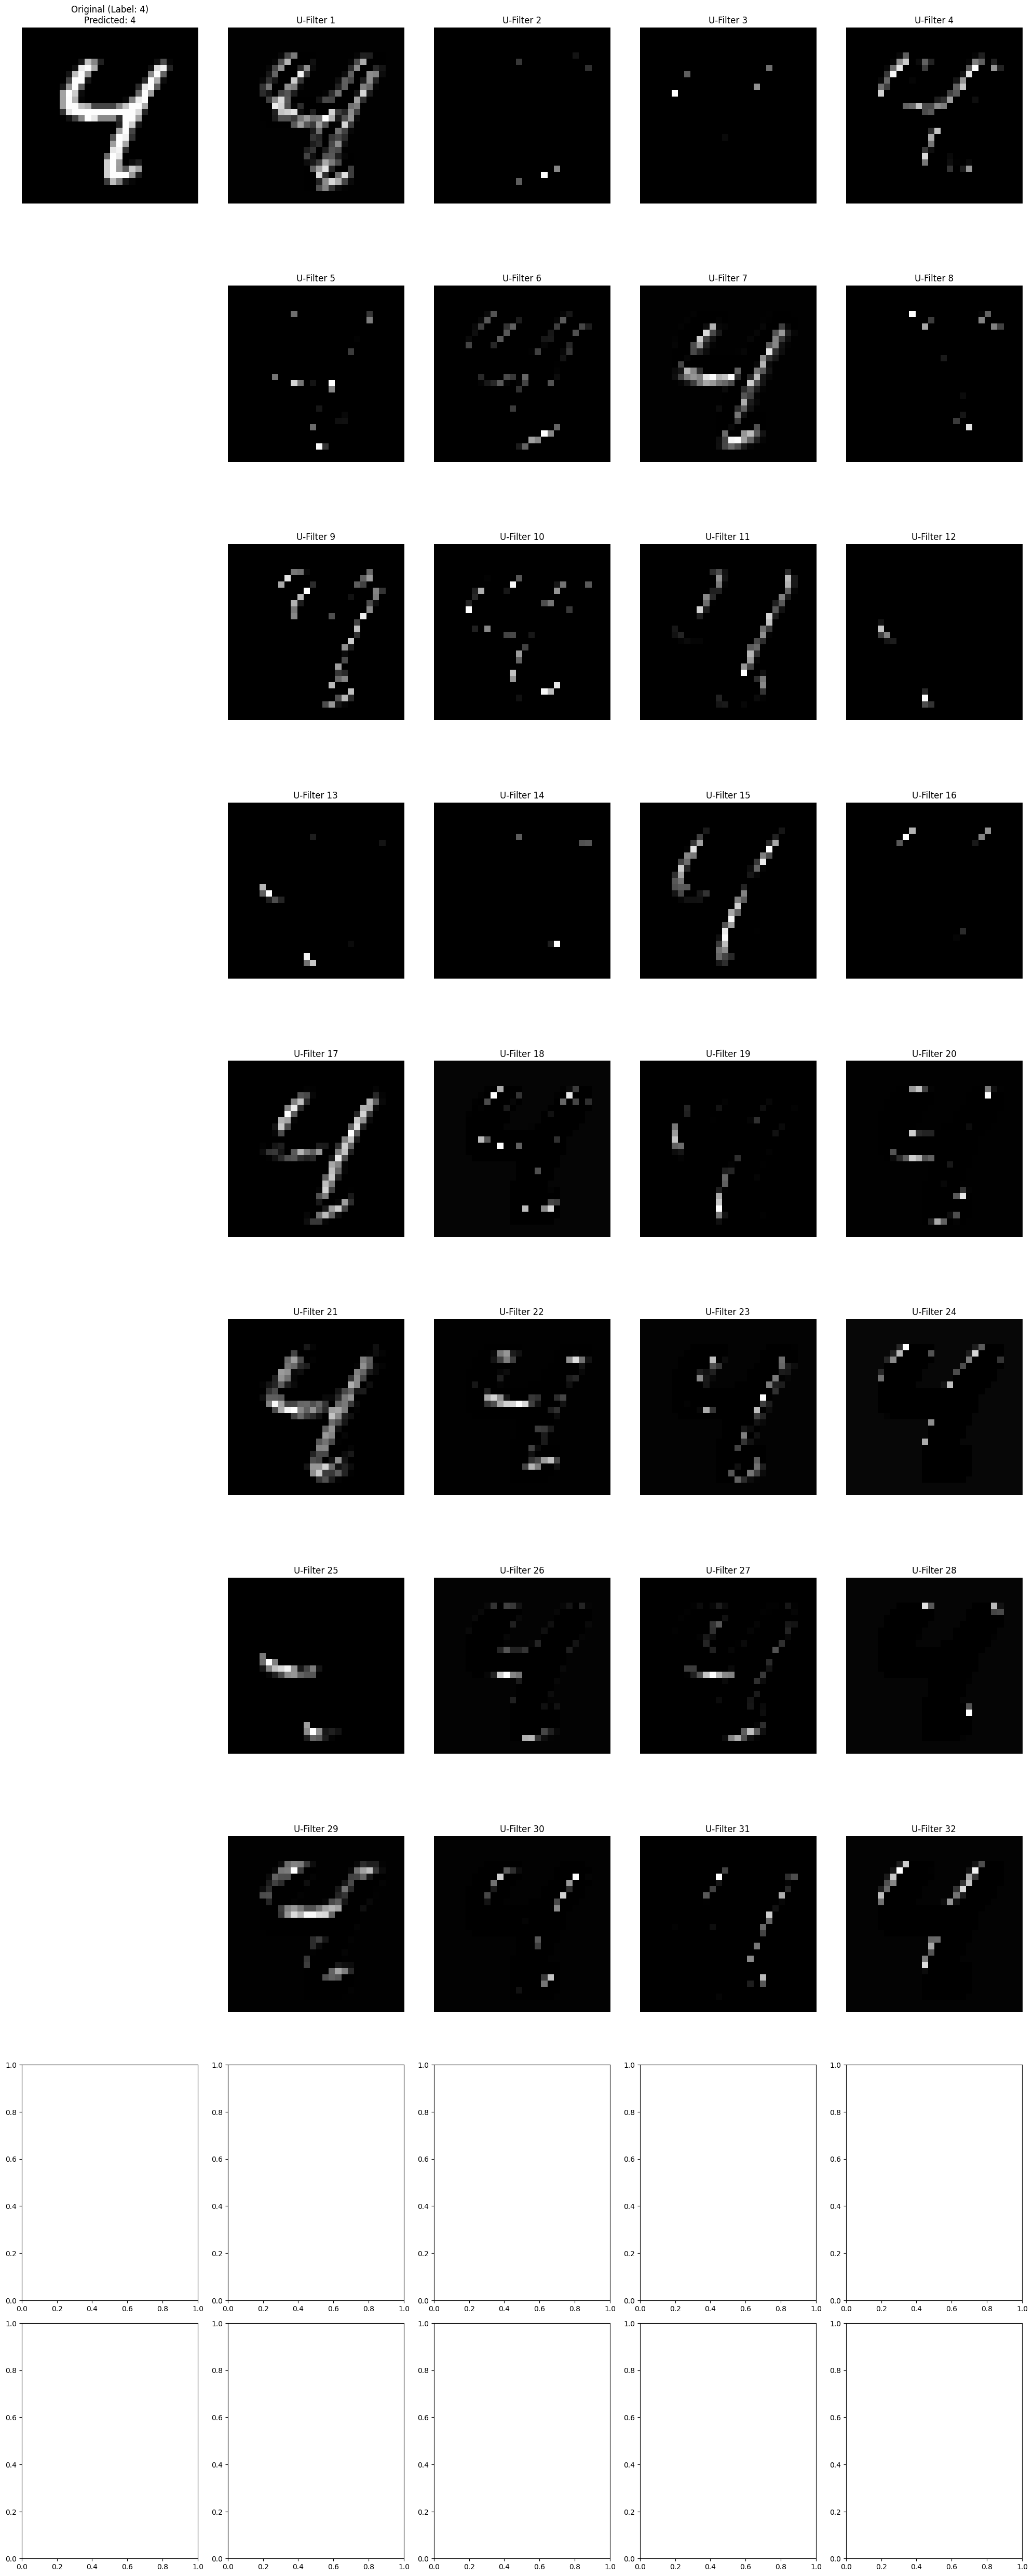

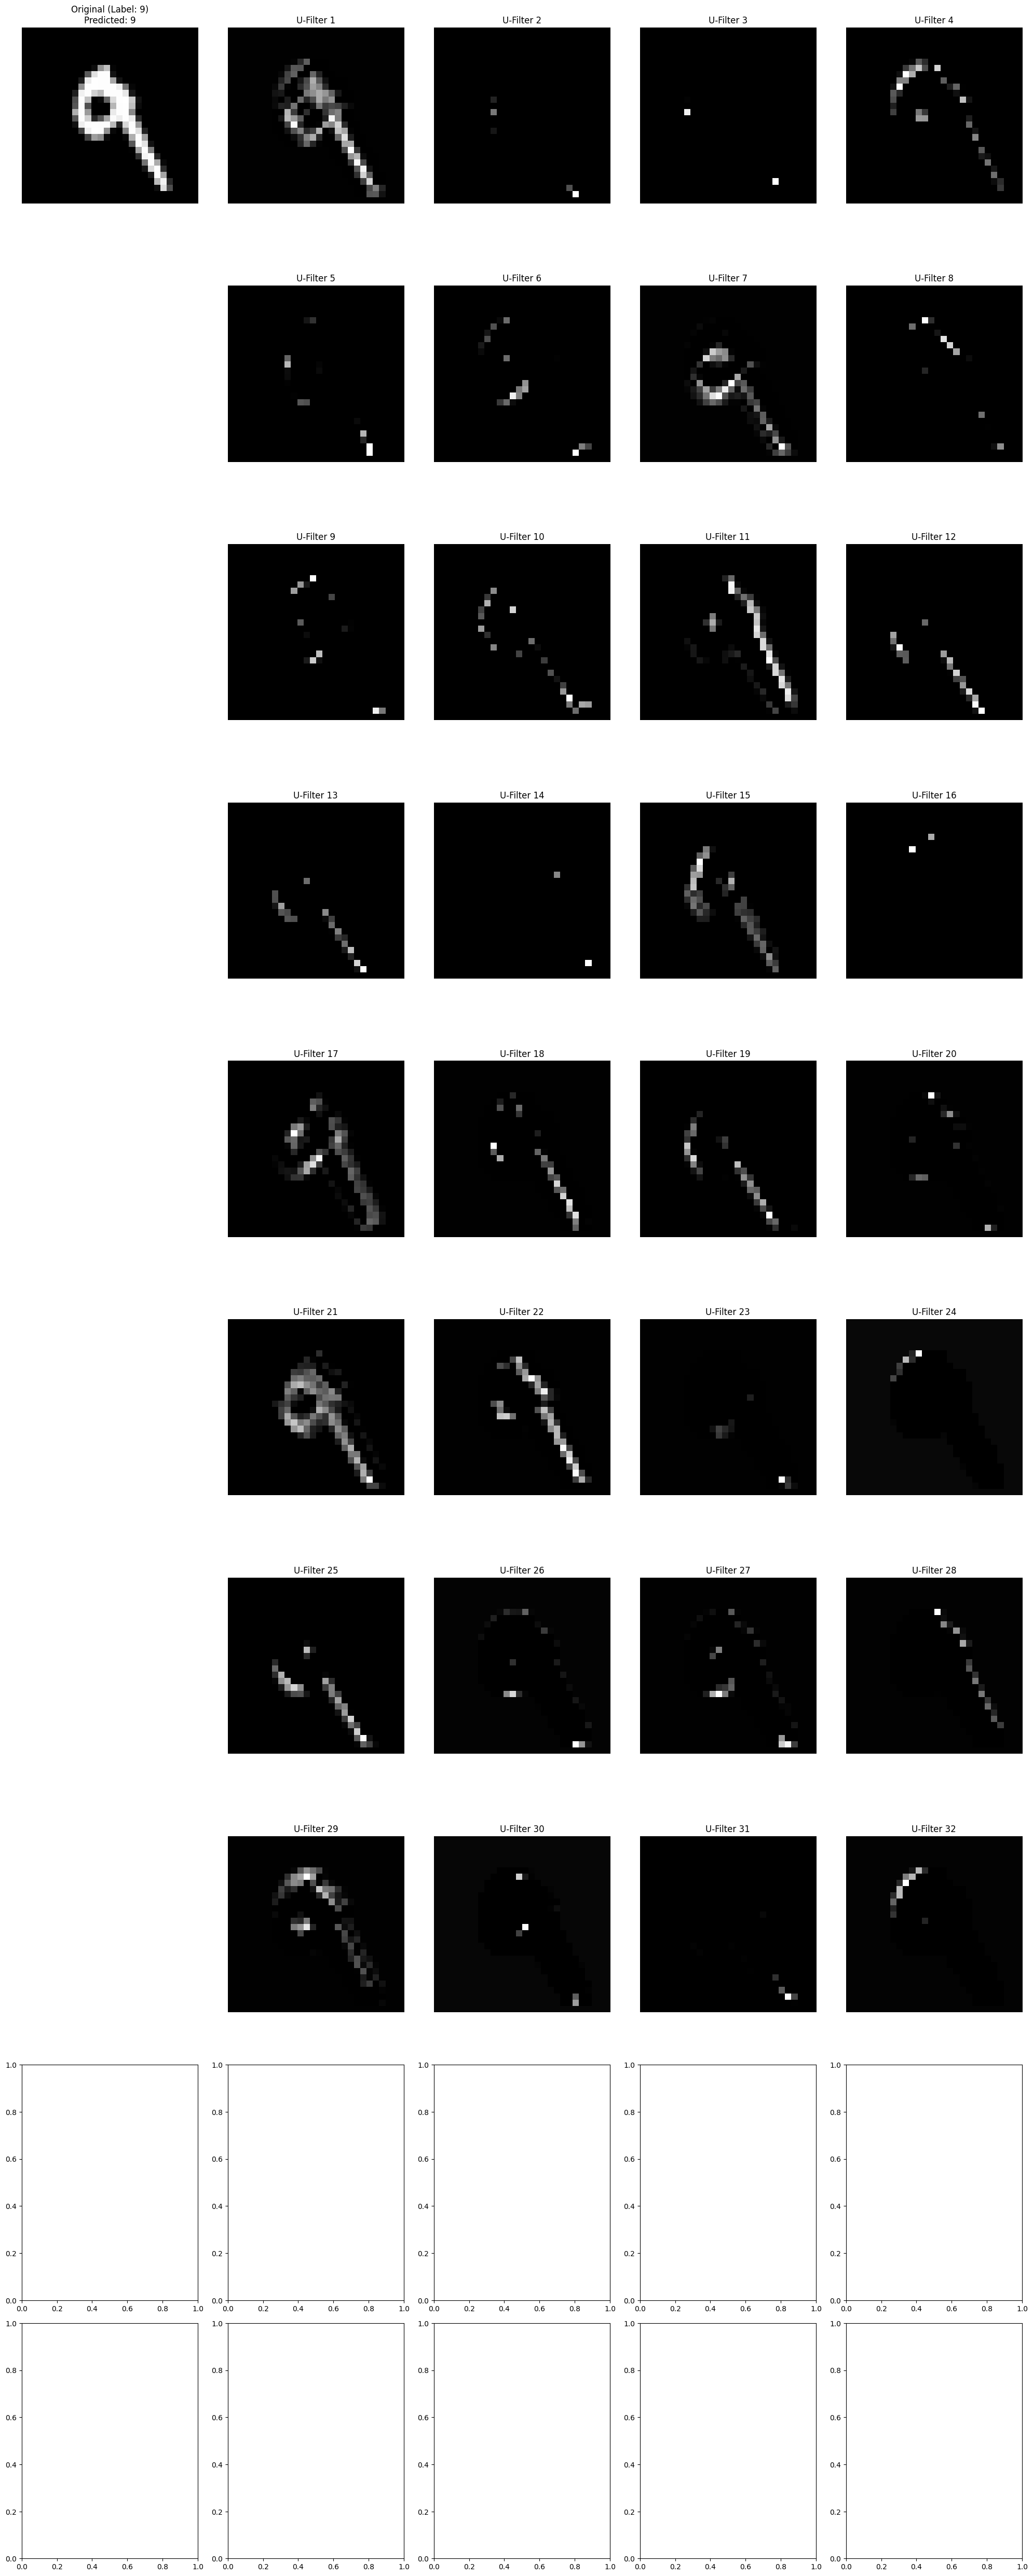

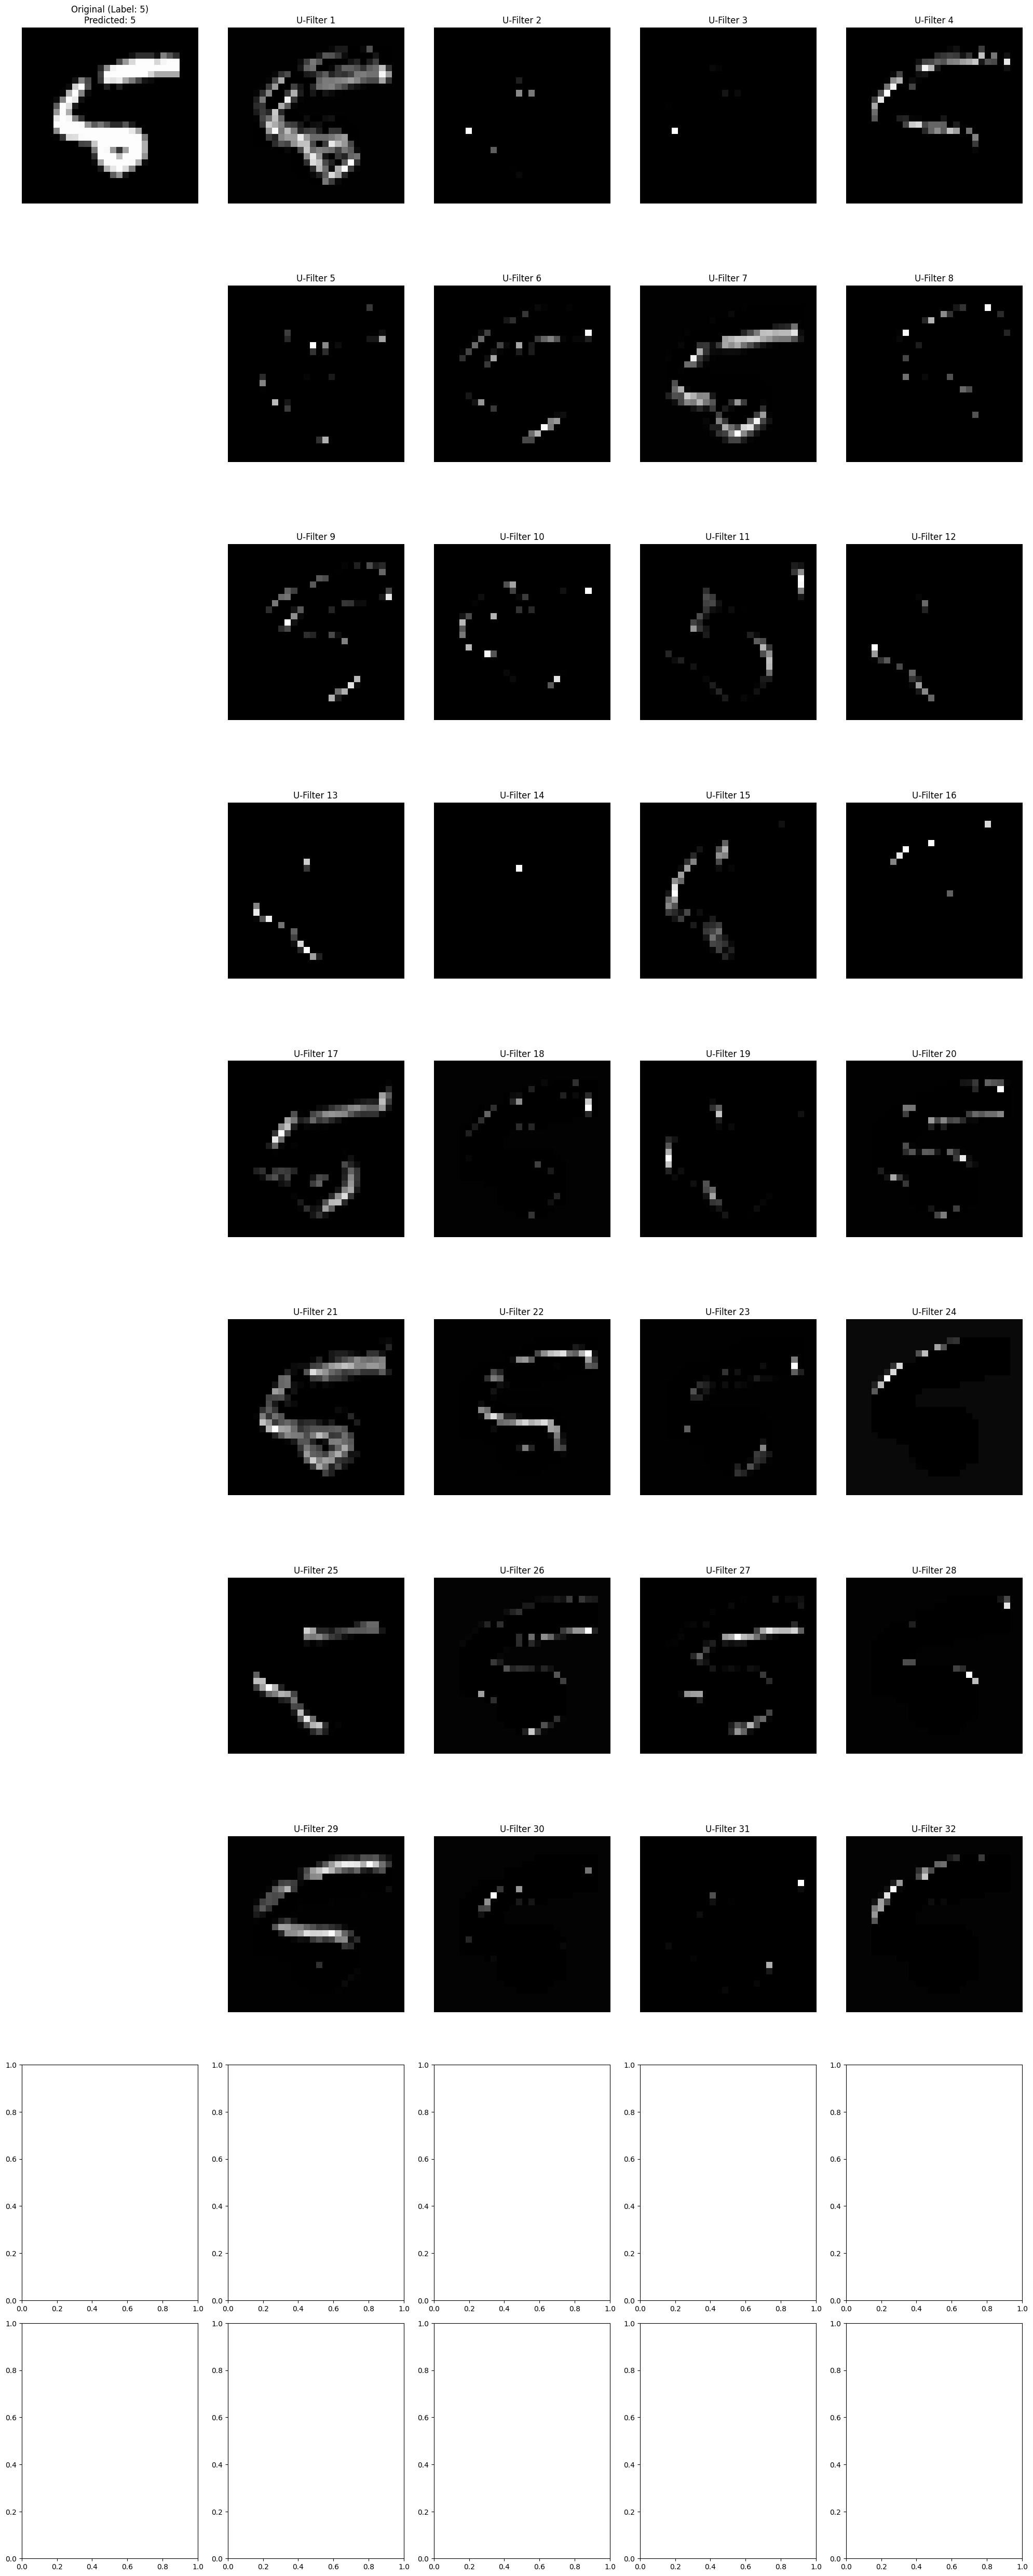

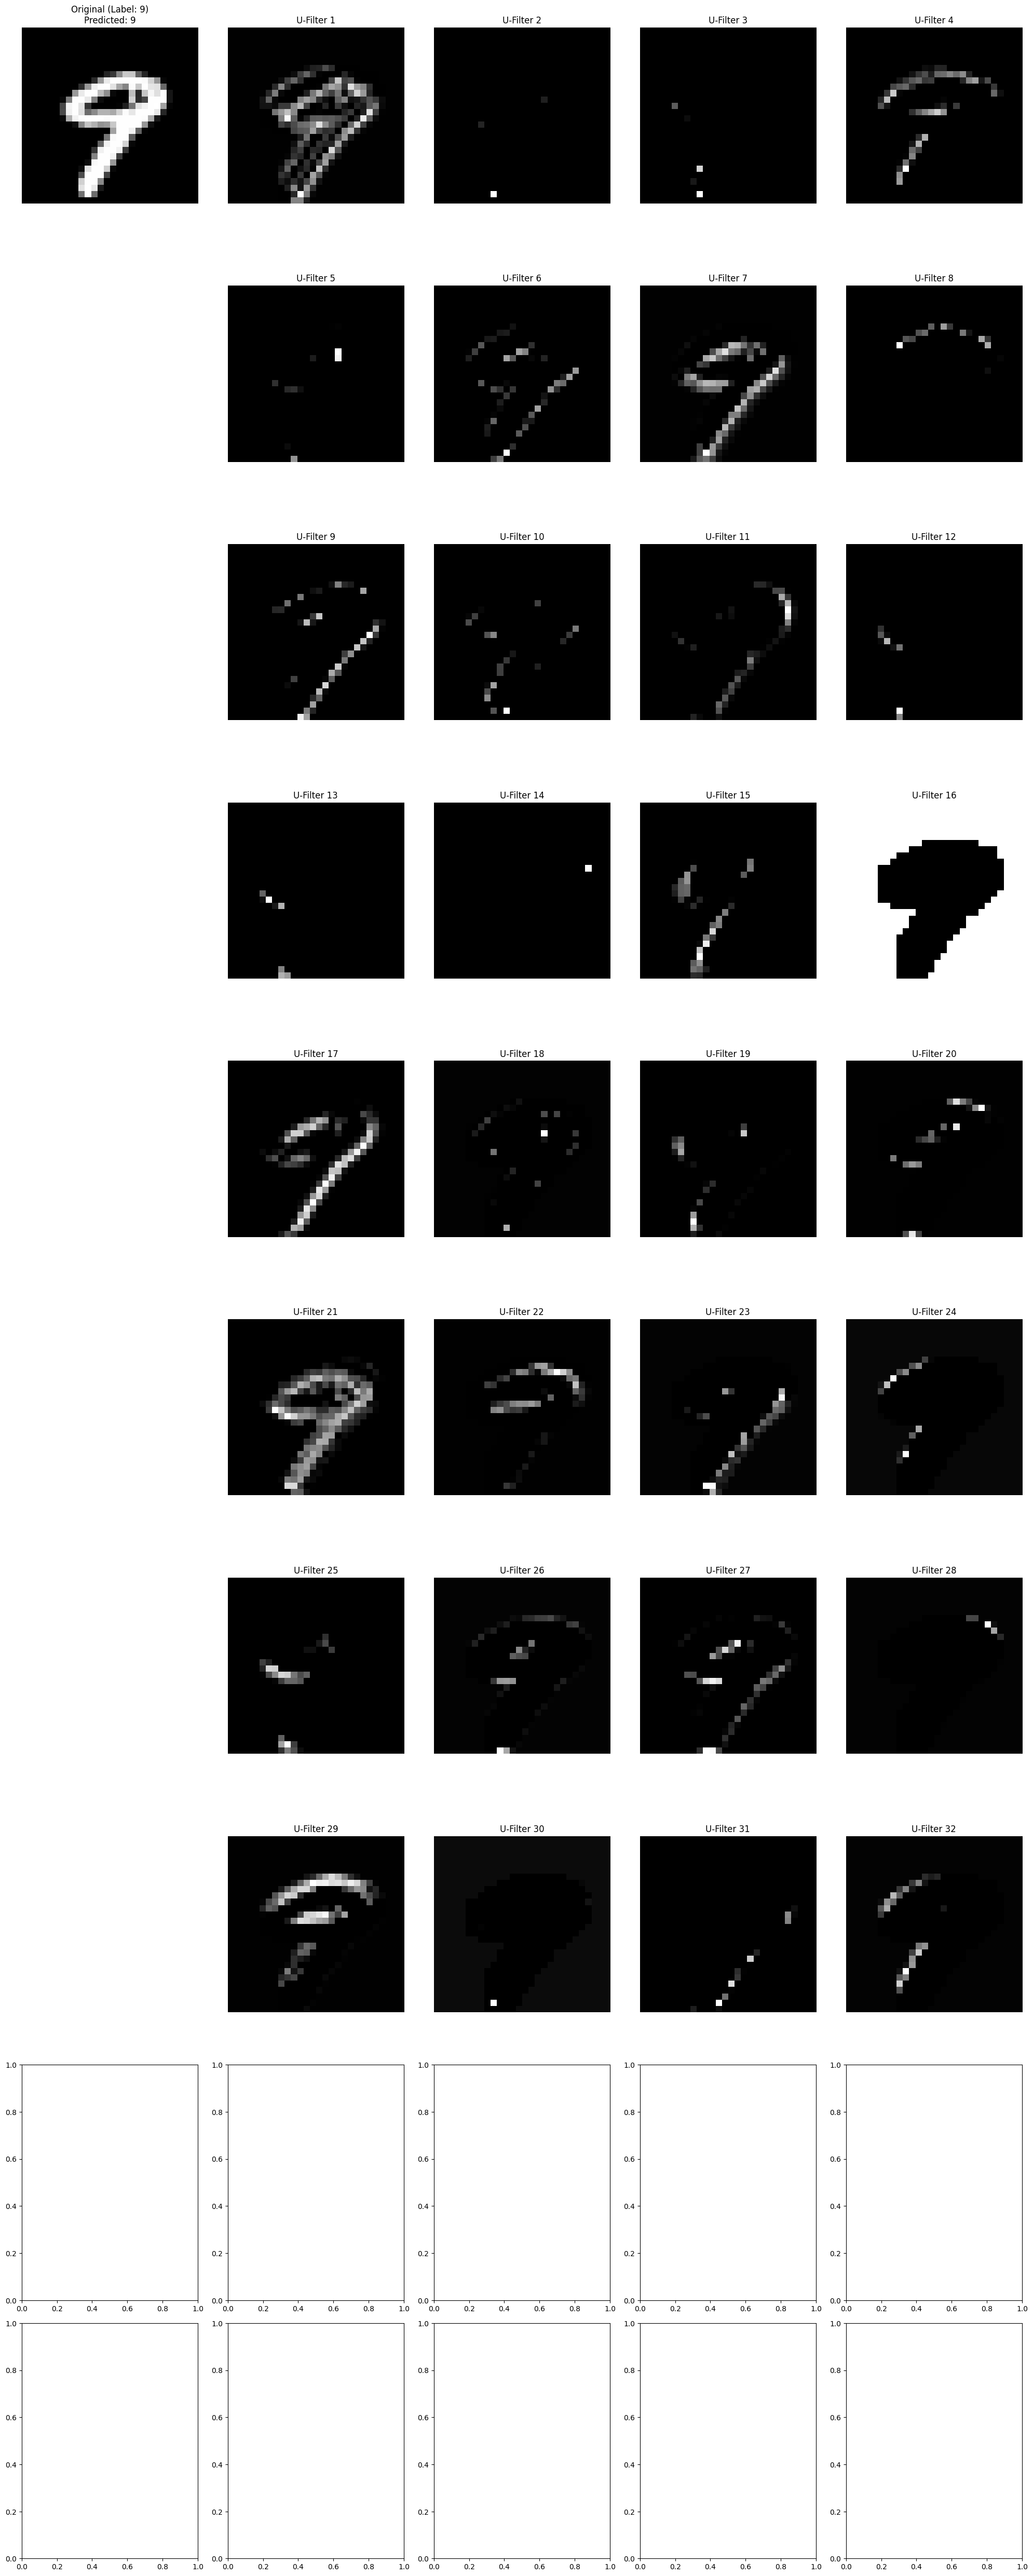

In [29]:
for example in eval_examples[:10]:
    label, img, out, act_imgs = example
    visualize_kernel_activations(img, label, act_imgs, out)